**Note!**

This notebook uses the `nilearn` package - which is not a requirement of `pynm` and must be installed.

To do so, uncomment the code in the cell below and run it.

In [1]:
#import sys
#!{sys.executable} -m pip install nilearn==0.9.2

In [3]:
import pandas as pd
import numpy as np
from pynm.pynm import PyNM
import seaborn as sns
import matplotlib.pyplot as plt

from nilearn import datasets
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure

/Users/harveyaa/miniconda3/envs/pynm/lib/python3.9/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


# **Model Selection**
In this tutorial we'll use a real dataset to demonstrate using cross-validation for model selection.

## **Cross-Validation**
The basic idea of cross-validation is to repeat the training and test process on the data multiple times to get a more stable evaluation of a model. In PyNM we've implemented cross-validation as a step before the ordinary model fit to help with model selection:
- For K iterations:
    - The training sample is shuffled and split again into training and test sets.
    - The model is fit on the training set and evaluated on the test set.
- The model evaluation for each fold is then averaged to get a final evaluation.
- Finally, the model is fit on the entire training sample and applied to the test sample (as usual).

## **Metrics**
PyNM implements the following metrics for model evaluation:
- Standardized Mean Squared Error (SMSE)
    - Applies for Centiles, LOESS, GP and GAMLSS models.
    - Smaller values are better.
- Root Mean Squared Error (RMSE)
    - Applies for Centiles, LOESS, GP and GAMLSS models.
    - Smaller values are better.
- Mean Standardized Log Loss (MSLL)
    - Applies for GP and GAMLSS models.
    - If value is negative, data is more likely under model than reference model (mean and standard deviation of training data).

To see the full implementation details, the code can be found under pynm/util.py.


## **Example**
In this example we'll use the ADHD resting-state dataset to demonstrate using cross-validation for model selection. The dataset consists of resting state fMRI scans for 40 subjects which are either controls or patients diagnosed with ADHD. Here we'll use `nilearn` to fetch the data and process it into connectomes, which are correlation matrices that capture how similar each pair of brain regions are in terms of their functional activity, and for demonstration purposes we'll choose an arbitrary edge from the connectome to fit our normative models to.

First, we'll use nilearn to fetch the data. Running the cell below will download ~2 GB of data to your machine.

In [4]:
# Download the dataset
adhd = datasets.fetch_adhd(n_subjects=None)


Dataset created in /Users/harveyaa/nilearn_data/adhd



 ...done. (1 seconds, 0 min)
Extracting data from /Users/harveyaa/nilearn_data/adhd/fbef5baff0b388a8c913a08e1d84e059/adhd40_metadata.tgz..... done.


Downloaded 36085760 of 44414948 bytes (81.2%,    0.7s remaining) ...done. (4 seconds, 0 min)
Extracting data from /Users/harveyaa/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_0010042.tgz..... done.


Downloaded 40296448 of 45583539 bytes (88.4%,    0.4s remaining) ...done. (3 seconds, 0 min)
Extracting data from /Users/harveyaa/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_0010064.tgz..... done.


Downloaded 41598976 of 45461055 bytes (91.5%,    0.3s remaining) ...done. (3 seconds, 0 min)
Extracting data from /Users/harveyaa/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_0010128.tgz..... done.


Downloaded 41844736 of 46216320 bytes (90.5%,    0.3s remaining) ...done. (3 seconds, 0 min)
Extracting data from /Users/harveyaa/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_0021019.tgz..... done.


Downloaded 13778944 of 20407901 bytes (67.5%,    0.5s remaining) ...done. (2 seconds, 0 min)
Extracting data from /Users/harveyaa/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_0023008.tgz..... done.


Downloaded 13901824 of 20706939 bytes (67.1%,    0.5s remaining) ...done. (2 seconds, 0 min)
Extracting data from /Users/harveyaa/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_0023012.tgz..... done.


Downloaded 67059712 of 72402326 bytes (92.6%,    0.4s remaining) ...done. (5 seconds, 0 min)
Extracting data from /Users/harveyaa/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_0027011.tgz..... done.


Downloaded 69607424 of 76184603 bytes (91.4%,    0.5s remaining) ...done. (6 seconds, 0 min)
Extracting data from /Users/harveyaa/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_0027018.tgz..... done.


Downloaded 69828608 of 70074120 bytes (99.6%,    0.0s remaining) ...done. (5 seconds, 0 min)
Extracting data from /Users/harveyaa/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_0027034.tgz..... done.


Downloaded 69091328 of 69291635 bytes (99.7%,    0.0s remaining) ...done. (5 seconds, 0 min)
Extracting data from /Users/harveyaa/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_0027037.tgz..... done.


Downloaded 40099840 of 41803342 bytes (95.9%,    0.1s remaining) ...done. (3 seconds, 0 min)
Extracting data from /Users/harveyaa/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_1019436.tgz..... done.


Downloaded 13950976 of 20763649 bytes (67.2%,    0.5s remaining) ...done. (2 seconds, 0 min)
Extracting data from /Users/harveyaa/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_1206380.tgz..... done.


Downloaded 13869056 of 20168043 bytes (68.8%,    0.5s remaining) ...done. (2 seconds, 0 min)
Extracting data from /Users/harveyaa/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_1418396.tgz..... done.


Downloaded 56098816 of 62682233 bytes (89.5%,    0.5s remaining) ...done. (5 seconds, 0 min)
Extracting data from /Users/harveyaa/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_1517058.tgz..... done.


Downloaded 13959168 of 20196558 bytes (69.1%,    0.4s remaining) ...done. (2 seconds, 0 min)
Extracting data from /Users/harveyaa/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_1552181.tgz..... done.


Downloaded 54845440 of 60663491 bytes (90.4%,    0.4s remaining) ...done. (5 seconds, 0 min)
Extracting data from /Users/harveyaa/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_1562298.tgz..... done.


Downloaded 12591104 of 20628764 bytes (61.0%,    0.6s remaining) ...done. (2 seconds, 0 min)
Extracting data from /Users/harveyaa/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_1679142.tgz..... done.


Downloaded 25378816 of 33119052 bytes (76.6%,    0.6s remaining) ...done. (3 seconds, 0 min)
Extracting data from /Users/harveyaa/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_2014113.tgz..... done.


Downloaded 40394752 of 45455025 bytes (88.9%,    0.4s remaining) ...done. (3 seconds, 0 min)
Extracting data from /Users/harveyaa/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_2497695.tgz..... done.


Downloaded 55902208 of 57992968 bytes (96.4%,    0.1s remaining) ...done. (4 seconds, 0 min)
Extracting data from /Users/harveyaa/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_2950754.tgz..... done.


Downloaded 55869440 of 67925261 bytes (82.3%,    0.9s remaining) ...done. (5 seconds, 0 min)
Extracting data from /Users/harveyaa/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_3007585.tgz..... done.


Downloaded 26607616 of 32919780 bytes (80.8%,    0.5s remaining) ...done. (3 seconds, 0 min)
Extracting data from /Users/harveyaa/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_3154996.tgz..... done.


Downloaded 54517760 of 59835286 bytes (91.1%,    0.4s remaining) ...done. (4 seconds, 0 min)
Extracting data from /Users/harveyaa/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_3205761.tgz..... done.


Downloaded 54452224 of 61857076 bytes (88.0%,    0.5s remaining) ...done. (5 seconds, 0 min)
Extracting data from /Users/harveyaa/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_3520880.tgz..... done.


Downloaded 55484416 of 59385206 bytes (93.4%,    0.4s remaining) ...done. (5 seconds, 0 min)
Extracting data from /Users/harveyaa/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_3624598.tgz..... done.


Downloaded 38649856 of 41518251 bytes (93.1%,    0.2s remaining) ...done. (3 seconds, 0 min)
Extracting data from /Users/harveyaa/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_3699991.tgz..... done.


Downloaded 21667840 of 32108848 bytes (67.5%,    1.0s remaining) ...done. (3 seconds, 0 min)
Extracting data from /Users/harveyaa/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_3884955.tgz..... done.


Downloaded 25837568 of 39415752 bytes (65.6%,    1.1s remaining) ...done. (3 seconds, 0 min)
Extracting data from /Users/harveyaa/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_3902469.tgz..... done.


Downloaded 49340416 of 59297020 bytes (83.2%,    0.8s remaining) ...done. (5 seconds, 0 min)
Extracting data from /Users/harveyaa/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_3994098.tgz..... done.


Downloaded 10141696 of 20157314 bytes (50.3%,    1.0s remaining) ...done. (2 seconds, 0 min)
Extracting data from /Users/harveyaa/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_4016887.tgz..... done.


Downloaded 10903552 of 21375806 bytes (51.0%,    1.0s remaining) ...done. (2 seconds, 0 min)
Extracting data from /Users/harveyaa/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_4046678.tgz..... done.


Downloaded 63561728 of 69914913 bytes (90.9%,    0.5s remaining) ...done. (6 seconds, 0 min)
Extracting data from /Users/harveyaa/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_4134561.tgz..... done.


Downloaded 39190528 of 45506732 bytes (86.1%,    0.5s remaining) ...done. (4 seconds, 0 min)
Extracting data from /Users/harveyaa/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_4164316.tgz..... done.


Downloaded 27877376 of 32363673 bytes (86.1%,    0.3s remaining) ...done. (2 seconds, 0 min)
Extracting data from /Users/harveyaa/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_4275075.tgz..... done.


Downloaded 68435968 of 73484949 bytes (93.1%,    0.4s remaining) ...done. (7 seconds, 0 min)
Extracting data from /Users/harveyaa/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_6115230.tgz..... done.


Downloaded 34643968 of 42188959 bytes (82.1%,    0.7s remaining) ...done. (4 seconds, 0 min)
Extracting data from /Users/harveyaa/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_7774305.tgz..... done.


Downloaded 63176704 of 70396354 bytes (89.7%,    0.6s remaining) ...done. (6 seconds, 0 min)
Extracting data from /Users/harveyaa/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_8409791.tgz..... done.


Downloaded 41869312 of 45075978 bytes (92.9%,    0.4s remaining) ...done. (5 seconds, 0 min)
Extracting data from /Users/harveyaa/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_8697774.tgz..... done.


Downloaded 61521920 of 63380505 bytes (97.1%,    0.4s remaining) ...done. (12 seconds, 0 min)
Extracting data from /Users/harveyaa/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_9744150.tgz..... done.


Downloaded 41893888 of 46607053 bytes (89.9%,    0.5s remaining) ...done. (4 seconds, 0 min)
Extracting data from /Users/harveyaa/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_9750701.tgz..... done.


Now that we have our data, we will need to process it from functional scans (4D data) into connectomes for each subject. To do that we need to download an atlas (to divide the brain into regions) and create `nilearn` objects to extract the activity from each region (`NiftiLabelsMasker`) and to compare the activity between regions (`ConnectivityMeasure`). 

Running this cell takes about a minute to process each connectome and downloads an atlas (~30MB). 

**Note:** 
We've sorted the `adhd.func` and `adhd.confounds` list of filenames to ensure that we are using the same ordering of subjects everywhere (ranked increasing by ID number).

In [5]:
# Download an atlas
atlas = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')

# Create the masker and correlation measure
masker = NiftiLabelsMasker(labels_img=atlas.maps, standardize=True)
correlation_measure = ConnectivityMeasure(kind='correlation')

# Get a connectome for each subject
connectomes=[]
for func,conf in zip(np.sort(adhd.func),np.sort(adhd.confounds)):
    ts = masker.fit_transform(func, confounds=conf)
    corr = correlation_measure.fit_transform([ts])[0]
    connectomes.append(corr)

connectomes = np.array(connectomes)


Dataset created in /Users/harveyaa/nilearn_data/fsl



Downloaded 12279808 of 25716861 bytes (47.8%,    1.1s remaining) ...done. (2 seconds, 0 min)
Extracting data from /Users/harveyaa/nilearn_data/fsl/245b1ae3f43e3ea47e2ed9f438694f4a/HarvardOxford.tgz..... done.


Now we'll build a DataFrame that we can use with PyNM. We'll grab the IDs, status (patient or control), gender, and age from the ADHD phenotypic information first and sort the values according to ID to match the order we processed the connectomes. Then we'll choose a random edge of the connectome to model for our example and add it to the dataframe.

**Note:**
We are building the DataFrame in this manner to ensure that pandas has the correct `dtype` for each column - if the DataFrame has `object` type for any of the columns it will cause an issue with the GAMLSS model (when the DataFrame is converted to R).

In [38]:
# Create a DataFrame
pheno = pd.DataFrame([int(x) for x in pd.DataFrame(adhd.phenotypic)['Subject']],columns=['id'])
pheno['status'] = pd.DataFrame(adhd.phenotypic)['adhd']
pheno['gender'] = [(x=='"M"')*1 for x in pd.DataFrame(adhd.phenotypic)['sex']]
pheno['age'] = [x for x in pd.DataFrame(adhd.phenotypic)['age']]

# Sort the values by id (same sorting as above)
pheno.sort_values('id',inplace=True)

# Add the response variable to the DataFrame
pheno['edge'] = connectomes[:,5,8]

# Normalize response variable for GAMLSS
pheno['edge'] = (pheno['edge'] - pheno['edge'].mean())/pheno['edge'].std()

### Visualize data

<AxesSubplot: xlabel='age', ylabel='edge'>

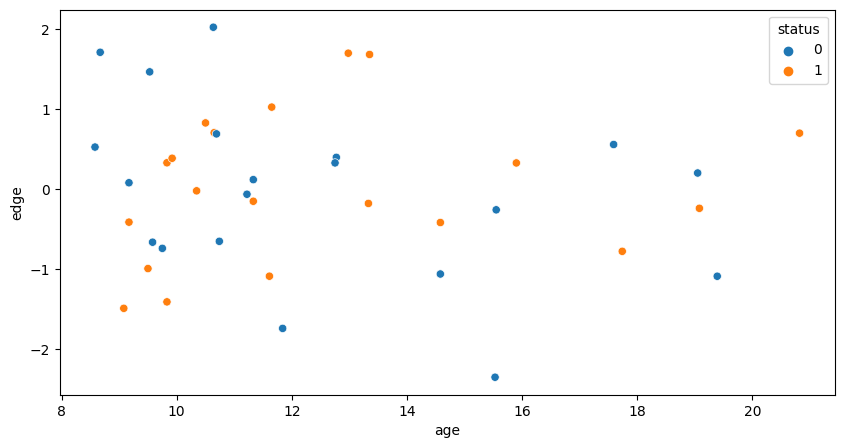

In [40]:
plt.figure(figsize=(10,5))
sns.scatterplot(x='age',y='edge',data=pheno,hue='status')

### Fit Normative Models with Cross-Validation
The number of folds of cross-validation can be set when calling each model using the `cv_folds` parameter. By default `cv_folds=1`, no cross-validation is performed, and the metrics are estimated on the training data only.

Here we'll run each model seperately so we can see the output of the cross-validation at each fold.

In [41]:
# Initialize pynm w/ data, confounds & bin parameters
m = PyNM(pheno,'edge','status',['age','c(gender)'],bin_width=15,bin_spacing=1)

Models will be fit on full set of controls.


In [42]:
# Run Centiles model
m.centiles_normative_model(cv_folds=5)

Starting 5 folds of CV...
CV Fold 0: RMSE=1.288 - SMSE=1.230
CV Fold 1: RMSE=1.396 - SMSE=1.436
CV Fold 2: RMSE=1.110 - SMSE=1.027
CV Fold 3: RMSE=0.717 - SMSE=1.019
CV Fold 4: RMSE=0.929 - SMSE=1.032
Done!
Average: RMSE=1.088 - SMSE=1.149


In [43]:
# Run LOESS model
m.loess_normative_model(cv_folds=5)

Starting 5 folds of CV...
CV Fold 0: RMSE=1.555 - SMSE=2.148
CV Fold 1: RMSE=1.145 - SMSE=1.371
CV Fold 2: RMSE=1.098 - SMSE=1.079
CV Fold 3: RMSE=0.600 - SMSE=0.821
CV Fold 4: RMSE=1.025 - SMSE=1.046
Done!
Average: RMSE=1.085 - SMSE=1.293


In [44]:
# Run GP model
m.gp_normative_model(cv_folds=5)

Starting 5 folds of CV...
CV Fold 0: RMSE=0.996 - SMSE=1.085 - MSLL=0.038
CV Fold 1: RMSE=0.975 - SMSE=1.000 - MSLL=0.000
CV Fold 2: RMSE=1.488 - SMSE=1.102 - MSLL=0.098
CV Fold 3: RMSE=1.213 - SMSE=1.056 - MSLL=-0.027
CV Fold 4: RMSE=0.655 - SMSE=1.123 - MSLL=-0.010
Done!
Average: RMSE=1.065 - SMSE=1.073 - MSLL=0.020


/Users/harveyaa/miniconda3/envs/pynm/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/harveyaa/miniconda3/envs/pynm/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/harveyaa/miniconda3/envs/pynm/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Use

In [45]:
# Run GAMLSS model
m.gamlss_normative_model(cv_folds=5)

Starting 5 folds of CV...


/Users/harveyaa/miniconda3/envs/pynm/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


GAMLSS-RS iteration 1: Global Deviance = 49.8774 
GAMLSS-RS iteration 2: Global Deviance = 44.9473 
GAMLSS-RS iteration 3: Global Deviance = 42.0058 
GAMLSS-RS iteration 4: Global Deviance = 40.7857 
GAMLSS-RS iteration 5: Global Deviance = 40.2466 
GAMLSS-RS iteration 6: Global Deviance = 2034.457 
GAMLSS-RS iteration 7: Global Deviance = 1276.049 
GAMLSS-RS iteration 8: Global Deviance = 520.1909 
GAMLSS-RS iteration 9: Global Deviance = 71.3435 
GAMLSS-RS iteration 10: Global Deviance = 39.3171 
GAMLSS-RS iteration 11: Global Deviance = 878.8682 
GAMLSS-RS iteration 12: Global Deviance = 111.0005 
GAMLSS-RS iteration 13: Global Deviance = 39.8047 
GAMLSS-RS iteration 14: Global Deviance = 46.2067 
GAMLSS-RS iteration 15: Global Deviance = 41.4369 
GAMLSS-RS iteration 16: Global Deviance = 40.8276 
GAMLSS-RS iteration 17: Global Deviance = 39.6037 
GAMLSS-RS iteration 18: Global Deviance = 39.0107 
GAMLSS-RS iteration 19: Global Deviance = 39.0304 
GAMLSS-RS iteration 20: Global Devi

### Visualize Models

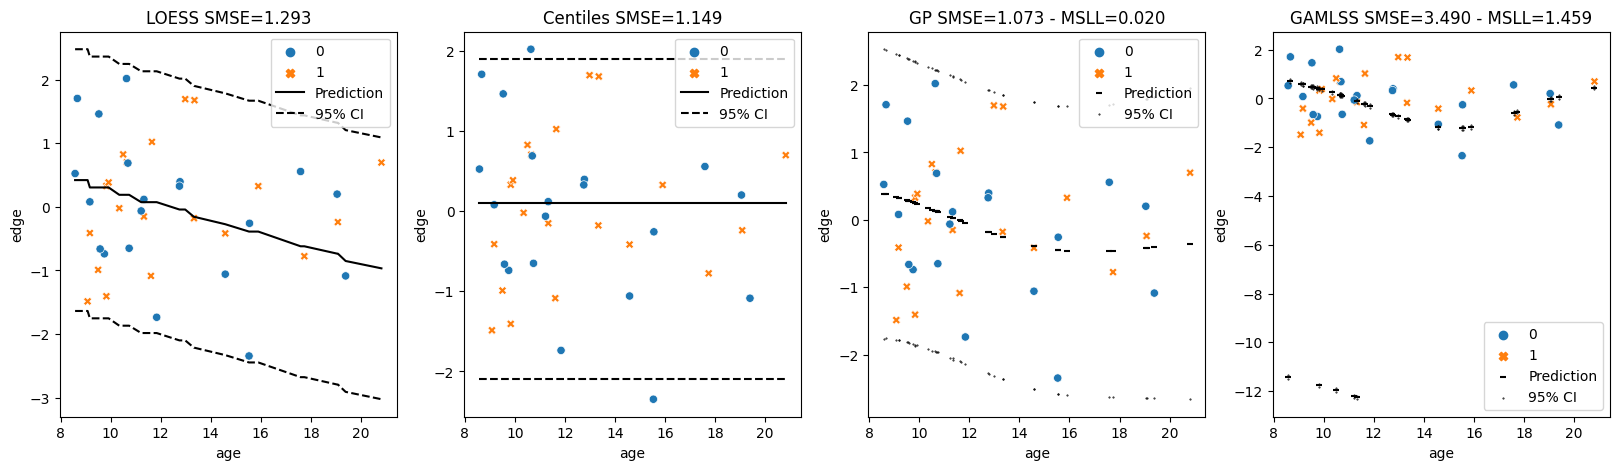

In [46]:
# Plot the data, model prediction, & 95% confidence interval
m.plot()

### Compare Metrics

We can take a quick view of all the metrics for the models that have been run automatically using the `report` function.

In [47]:
# View all the metrics for each model
m.report()

------
Report
------
========= SMSE - RMSE - MSLL
LOESS     1.29   1.08   N/A
Centiles  1.15   1.09   N/A
GP        1.07   1.07   0.02
GAMLSS    3.49   2.86   1.46


We can also access the metrics (with full precision) individually, they are stored as attributes of the PyNM object in the following format `{metric}_{model}`.

In [48]:
# View a single metric (full precision)
m.SMSE_GP

1.0731271374089988

## **Summary**
- Cross-validation is a tool to assist model selection by giving a more stable evaluation of model performance.
- PyNM implements Standardized Mean Squared Error (SMSE) and Root Mean Squared Error (RMSE) for all models, and Mean Standardized Log Loss (MSLL) for the GP and GAMLSS models.
- We can set the number of folds of cross-validation using the `cv_folds` parameter of each model.
- We can get an overview of the model evaluations using the `report` function.
- We can access the metrics individually as attributes in the format `{metric}_{model}`.

## **Resources**
- For discussion of MSLL see the Dinga et al. 2021 [preprint](https://doi.org/10.1101/2021.06.14.448106)

### **Next up:** Using results of normative modeling for downstream analyses using a held out training sample!